<a href="https://colab.research.google.com/github/mohammadreza-mohammadi94/NLP-Projects/blob/main/Key%20Phrase%20Extractor%20-%20SpaCy%20%26%20LogisticRegression/KeyphraseExtractor_SpaCy_%26_LogisticRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries & Setups

In [3]:
"""
SpaCy Keyphrase Extraction with Machine Learning

This script extracts custom keyphrases from the Reuters Corpus using SpaCy, applies
complex linguistic rules, computes features (length, frequency, TF-IDF, NER), and ranks
keyphrases using a logistic regression model. It generates analytical reports and visualizations.
"""
import nltk
import spacy
import pandas as pd
from nltk.corpus import reuters
from collections import Counter
from spacy.language import Language
from spacy.tokens import Doc
import logging
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import numpy as np
import warnings

# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Setup Warnings
warnings.filterwarnings('ignore')

# Key Phrase Extractor


Text 1: ASIAN EXPORTERS FEAR DAMAGE FROM U.S.-JAPAN RIFT
  Mounting trade friction between the
  U.S. And Ja...
Keyphrases:
- South Korea (Score: 0.783)
- South Korea (Score: 0.783)
- South Korea (Score: 0.783)
- leading Japanese electronics firm Matsushita Electric
  Industrial Co Ltd (Score: 0.638)
- He said (Score: 0.572)
- He said (Score: 0.572)
- He said (Score: 0.572)
- He said (Score: 0.572)
- other businessmen (Score: 0.54)
- Hong Kong (Score: 0.539)
- Hong Kong (Score: 0.539)
- Prime Minister
  Yasuhiro Nakasone's avowed fiscal reform program (Score: 0.511)
- 7.1 billion
  dlrs (Score: 0.39)
- a few months (Score: 0.39)
- the first half (Score: 0.39)
- official said (Score: 0.303)
- he said (Score: 0.303)
- he said (Score: 0.303)
- official said (Score: 0.303)
- he said (Score: 0.303)
- official said (Score: 0.303)
- Tom
  Murtha (Score: 0.275)
- U.S. Products (Score: 0.275)
- Makoto
  Kuroda (Score: 0.275)
- Lawrence Mills (Score: 0.275)
- Paul Sheen (Score: 0.275)
- 15.6 bi

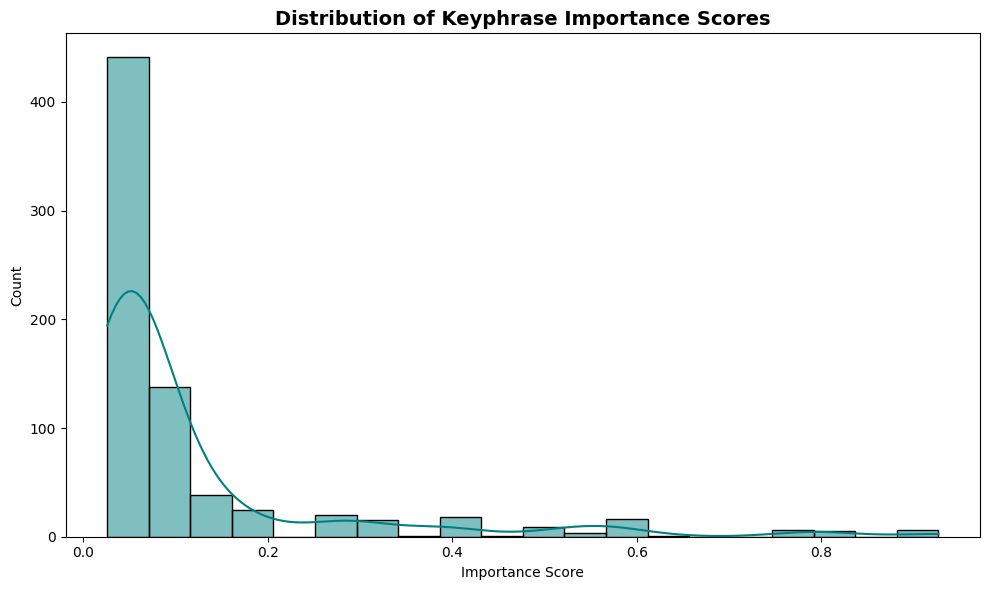

In [7]:
class KeyphraseExtractor:
    """A class to extract and rank keyphrases using SpaCy and machine learning."""

    def __init__(self, model_name = "en_core_web_sm", max_docs = 10):
        """
        Initialize SpaCy model and Reuters Corpus.

        Args:
            model_name (str): SpaCy model name (default: 'en_core_web_sm').
            max_docs (int): Maximum number of Reuters documents to process (default: 10).
        """
        try:
            self.nlp = spacy.load(model_name)
            logger.info(f"SpaCy model '{model_name}' loaded successfully")
        except OSError as e:
            logger.error(f"Model '{model_name}' not found. Run 'python -m spacy download {model_name}'")
            raise e

        try:
            nltk.download("reuters", quiet=True)
            self.corpus = [reuters.raw(fileid) for fileid in reuters.fileids()[:max_docs]]
            logger.info(f"Loaded {len(self.corpus)} documents from Reuters Corpus")
        except Exception as e:
            logger.error(f"Failed to load Reuters Corpus: {e}")
            raise e

        self.keyphrases = []
        self.tfidf_vectorizer = TfidfVectorizer()
        self.model = LogisticRegression(random_state=42)
        self.scaler = StandardScaler()
        self.doc_keyphrases: List[List[Dict]] = []

    def add_custom_component(self):
        """Add a custom SpaCy component for keyphrase extraction."""
        @Language.component("custom_keyphrase_extractor")
        def custom_keyphrase_extractor(doc: Doc) -> Doc:
            keyphrases = []
            # Rule 1: Noun chunks with specific patterns (NOUN+NOUN, ADJ+NOUN)
            for chunk in doc.noun_chunks:
                if len(chunk) >= 2:
                    pos_pattern = [token.pos_ for token in chunk]
                    if ("NOUN" in pos_pattern and ("NOUN" in pos_pattern[1:] or "ADJ" in pos_pattern)) or \
                       chunk.text in [ent.text for ent in doc.ents]:
                        keyphrases.append({
                            "text": chunk.text,
                            "start": chunk.start,
                            "end": chunk.end,
                            "is_entity": chunk.text in [ent.text for ent in doc.ents]
                        })

            # Rule 2: Dependency-based patterns (e.g., subject + verb)
            for token in doc:
                if token.dep_ in ("nsubj", "dobj") and token.head.pos_ == "VERB":
                    phrase = f"{token.text} {token.head.text}"
                    keyphrases.append({
                        "text": phrase,
                        "start": min(token.i, token.head.i),
                        "end": max(token.i, token.head.i) + 1,
                        "is_entity": False
                    })

            doc._.keyphrases = keyphrases
            return doc

        try:
            Doc.set_extension("keyphrases", default=[], force=True)
            self.nlp.add_pipe("custom_keyphrase_extractor", last=True)
            logger.info("Custom keyphrase extractor component added")
        except ValueError as e:
            logger.warning(f"Component error: {e}")

    def extract_keyphrases(self):
        """Process corpus and extract keyphrases."""
        try:
            docs = list(self.nlp.pipe(self.corpus))
            for doc in docs:
                self.doc_keyphrases.append(doc._.keyphrases)
            self.keyphrases = [kp for doc_kps in self.doc_keyphrases for kp in doc_kps]
            logger.info(f"Extracted {len(self.keyphrases)} keyphrases")
        except Exception as e:
            logger.error(f"Keyphrase extraction error: {e}")
            raise e

    def compute_features(self):
        """Compute features for each keyphrase (length, frequency, TF-IDF, NER)."""
        try:
            # Frequency
            phrase_freq = Counter(kp["text"] for kp in self.keyphrases)

            # TF-IDF
            all_phrases = [kp["text"] for kp in self.keyphrases]
            if all_phrases:
                tfidf_matrix = self.tfidf_vectorizer.fit_transform(all_phrases)
                tfidf_scores = tfidf_matrix.toarray().flatten()
            else:
                tfidf_scores = [0] * len(self.keyphrases)

            # Compute features
            features = []
            for i, kp in enumerate(self.keyphrases):
                features.append({
                    "text": kp["text"],
                    "length": len(kp["text"].split()),
                    "frequency": phrase_freq[kp["text"]],
                    "tfidf": tfidf_scores[i] if i < len(tfidf_scores) else 0,
                    "is_entity": int(kp["is_entity"])
                })
            logger.info("Computed features for keyphrases")
            return features
        except Exception as e:
            logger.error(f"Feature computation error: {e}")
            raise e

    def train_model(self, features):
        """Train a logistic regression model with synthetic data."""
        try:
            # Synthetic training data
            synthetic_data = [
                ([3, 2, 0.5, 1], 1),  # e.g., "stock market"
                ([2, 1, 0.2, 0], 0),  # e.g., "rose sharply"
                ([4, 3, 0.7, 1], 1),  # e.g., "weak jobs report"
                ([1, 1, 0.1, 0], 0),  # e.g., "pct"
                ([2, 2, 0.4, 1], 1),  # e.g., "U.S."
                ([3, 1, 0.3, 0], 0),  # e.g., "fell sharply"
                ([2, 3, 0.6, 1], 1),  # e.g., "industrial output"
                ([1, 1, 0.05, 0], 0), # e.g., "in"
                ([3, 2, 0.5, 0], 1),  # e.g., "jobs report"
                ([2, 1, 0.2, 0], 0),  # e.g., "said"
                ([4, 4, 0.8, 1], 1),  # e.g., "new trade agreement"
                ([1, 1, 0.1, 0], 0),  # e.g., "after"
                ([3, 2, 0.4, 1], 1),  # e.g., "Japan"
                ([2, 1, 0.3, 0], 0),  # e.g., "rose"
                ([2, 2, 0.5, 1], 1),  # e.g., "trade deal"
                ([1, 1, 0.05, 0], 0), # e.g., "by"
                ([3, 3, 0.6, 1], 1),  # e.g., "economic growth"
                ([2, 1, 0.2, 0], 0),  # e.g., "fell"
                ([2, 2, 0.4, 1], 1),  # e.g., "bank policy"
                ([1, 1, 0.1, 0], 0),  # e.g., "with"
            ]
            X_train = [d[0] for d in synthetic_data]
            y_train = [d[1] for d in synthetic_data]

            # Prepare actual features
            X = [[f["length"], f["frequency"], f["tfidf"], f["is_entity"]] for f in features]

            # Scale features
            X_train_scaled = self.scaler.fit_transform(X_train)
            X_scaled = self.scaler.transform(X)

            # Train model
            self.model.fit(X_train_scaled, y_train)
            scores = self.model.predict_proba(X_scaled)[:, 1]  # Probability of being "important"

            # Add scores to features
            for i, f in enumerate(features):
                f["score"] = round(scores[i], 3)

            logger.info("Model trained and scores assigned")
            return features
        except Exception as e:
            logger.error(f"Model training error: {e}")
            raise e

    def generate_report(self, features):
        """Generate analytical report."""
        try:
            df = pd.DataFrame(features)
            df = df.sort_values(by="score", ascending=False)

            # Summary statistics
            summary = {
                "Total Keyphrases": len(features),
                "Average Score": round(df["score"].mean(), 3) if not df.empty else 0,
                "Unique Keyphrases": len(set(f["text"] for f in features))
            }
            logger.info(f"Report summary: {summary}")
            return df, summary
        except Exception as e:
            logger.error(f"Report generation error: {e}")
            raise e

    def display_results(self, df, summary):
        """Display results for each document and summary."""
        try:
            for i, doc_kps in enumerate(self.doc_keyphrases):
                print(f"\nText {i+1}: {self.corpus[i][:100]}...")
                doc_df = df[df["text"].isin([kp["text"] for kp in doc_kps])]
                if not doc_df.empty:
                    print("Keyphrases:")
                    for _, row in doc_df[["text", "score"]].iterrows():
                        print(f"- {row['text']} (Score: {row['score']})")

            print("\nSummary:")
            for key, value in summary.items():
                print(f"- {key}: {value}")
        except Exception as e:
            logger.error(f"Display error: {e}")
            raise e

    def visualize_results(self, df, output_dir = "output"):
        """Visualize score distribution."""
        try:
            Path(output_dir).mkdir(exist_ok=True)

            plt.figure(figsize=(10, 6))
            sns.histplot(df["score"], bins=20, kde=True, color="teal")
            plt.title("Distribution of Keyphrase Importance Scores", fontsize=14, fontweight="bold")
            plt.xlabel("Importance Score")
            plt.ylabel("Count")
            plt.tight_layout()
            plt.savefig(f"{output_dir}/score_distribution.png")
            plt.show()

            logger.info("Visualization saved")
        except Exception as e:
            logger.error(f"Visualization error: {e}")
            raise e

    def save_results(self, df, filepath = "output/keyphrase_results.csv"):
        """Save results to a CSV file."""
        try:
            Path(filepath).parent.mkdir(exist_ok=True)
            df.to_csv(filepath, index=False)
            logger.info(f"Results saved to {filepath}")
        except Exception as e:
            logger.error(f"Save error: {e}")
            raise e

def main():
    """Main function to execute keyphrase extraction and ranking."""
    try:
        # Initialize extractor
        extractor = KeyphraseExtractor(max_docs=10)

        # Add custom component
        extractor.add_custom_component()

        # Extract keyphrases
        extractor.extract_keyphrases()

        # Compute features
        features = extractor.compute_features()

        # Train model and score keyphrases
        features = extractor.train_model(features)

        # Generate report
        df, summary = extractor.generate_report(features)

        # Display results
        extractor.display_results(df, summary)

        # Visualize results
        extractor.visualize_results(df)

        # Save results
        extractor.save_results(df)
    except Exception as e:
        logger.error(f"Main execution error: {e}")


main()